In [21]:
import numpy as np
from scipy.integrate import solve_ivp
import random
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols, Function, functions
import matplotlib.pyplot as plt
import numpy as np
import graphviz

In [23]:
# Define the system function
def vanderpol_oscillator(t, y):
    x1, x2 = y
    
    #parameters
    u = 2
    
    #expressions
    dx1_dt = x2
    dx2_dt = -x1 + u*(1-x1**2)*x2

    return dx1_dt,dx2_dt

In [24]:
# Initial conditions and parameters
x_0 = [1, 0]
T_fin = 15
t_span = (0, T_fin)

# Time evaluation points
t_eval = np.linspace(0, T_fin, 1000)

# Solve ODE using solve_ivp
sol = solve_ivp(vanderpol_oscillator, t_span, x_0, t_eval=t_eval)

# Convert solution to Pandas DataFrame
df = pd.DataFrame({
    'Time': sol.t,
    'x1': sol.y[0],
    'x2': sol.y[1]
})

# Print the first few rows of the solution DataFrame
print(df.head())

       Time        x1        x2
0  0.000000  1.000000  0.000000
1  0.015015  0.999887 -0.015014
2  0.030030  0.999549 -0.030026
3  0.045045  0.998986 -0.045032
4  0.060060  0.998197 -0.060030


In [25]:
df.set_index("Time", inplace=True)

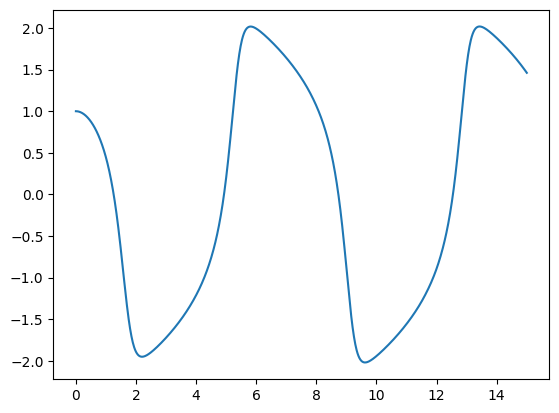

In [26]:
plt.plot(df['x1'])

In [27]:
df['u'] = 2
df['x1^2'] = df['x1']**2
df['x2^2'] = df['x2']**2
df['x1^2,x2'] = (df['x1']**2)*df['x2']
df['x2^2,x1'] = (df['x2']**2)*df['x1']
df['dx1_dt'] = df['x2']
df['dx2_dt'] = -df['x1'] + 2*(1-df['x1']**2)*df['x2']

In [28]:
df

,x1,x2,u,x1^2,x2^2,"x1^2,x2","x2^2,x1",dx1_dt,dx2_dt
Time,,,,,,,,,
0.000000,1.000000,0.000000,2,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
0.015015,0.999887,-0.015014,2,0.999775,0.000225,-0.015011,0.000225,-0.015014,-0.999894
0.030030,0.999549,-0.030026,2,0.999098,0.000902,-0.029999,0.000901,-0.030026,-0.999603
0.045045,0.998986,-0.045032,2,0.997972,0.002028,-0.044941,0.002026,-0.045032,-0.999168
0.060060,0.998197,-0.060030,2,0.996397,0.003604,-0.059814,0.003597,-0.060030,-0.998629
...,...,...,...,...,...,...,...,...,...
14.939940,1.492153,-0.501230,2,2.226519,0.251232,-1.115999,0.374876,-0.501230,-0.262615
14.954955,1.484598,-0.505218,2,2.204031,0.255245,-1.113515,0.378936,-0.505218,-0.268003
14.969970,1.476982,-0.509287,2,2.181477,0.259373,-1.110997,0.383089,-0.509287,-0.273562


In [29]:
X = df.drop(columns = ['dx1_dt','dx2_dt'])
y1 = df['dx1_dt']
y2 = df['dx2_dt']

In [30]:
X

,x1,x2,u,x1^2,x2^2,"x1^2,x2","x2^2,x1"
Time,,,,,,,
0.000000,1.000000,0.000000,2,1.000000,0.000000,0.000000,0.000000
0.015015,0.999887,-0.015014,2,0.999775,0.000225,-0.015011,0.000225
0.030030,0.999549,-0.030026,2,0.999098,0.000902,-0.029999,0.000901
0.045045,0.998986,-0.045032,2,0.997972,0.002028,-0.044941,0.002026
0.060060,0.998197,-0.060030,2,0.996397,0.003604,-0.059814,0.003597
...,...,...,...,...,...,...,...
14.939940,1.492153,-0.501230,2,2.226519,0.251232,-1.115999,0.374876
14.954955,1.484598,-0.505218,2,2.204031,0.255245,-1.113515,0.378936
14.969970,1.476982,-0.509287,2,2.181477,0.259373,-1.110997,0.383089


In [31]:
function_set = ['add','sub']
est_gp = SymbolicRegressor(population_size=10000,
                           generations=15,function_set = function_set, stopping_criteria=0.01,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.2, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [32]:
est_gp.fit(X, y1)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.50          5.22643        5                0                0      1.77m


SymbolicRegressor(function_set=['add', 'sub'], generations=15, max_samples=0.9,
                  p_crossover=0.6, p_hoist_mutation=0.2, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=10000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [33]:
X0 = X['x1']
X1 = X['x2']
# Compute y_pred uiven structure
y_pred = X1

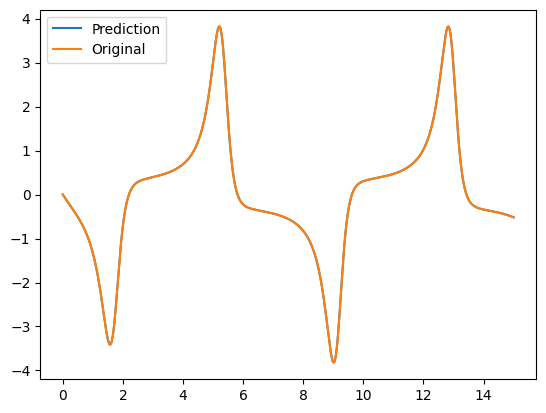

In [34]:
# Plot both scaled values
plt.plot(y_pred, label='Prediction')
plt.plot(y1, label='Original')
plt.legend()
plt.show()

In [36]:
function_set = ['add','sub']
y2_gp = SymbolicRegressor(population_size=10000,
                           generations=15,function_set = function_set, stopping_criteria=0.01,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.2, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [37]:
est_gp.fit(X, y2)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.50          5.86247        7          1.16202          1.14889      1.82m
   1     5.12          2.64203        5          1.02542          1.29772      1.18m
   2     4.72          2.18147        9      1.29649e-16      1.24345e-16      1.06m


SymbolicRegressor(function_set=['add', 'sub'], generations=15, max_samples=0.9,
                  p_crossover=0.6, p_hoist_mutation=0.2, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=10000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [39]:
X.columns

Index(['x1', 'x2', 'u', 'x1^2', 'x2^2', 'x1^2,x2', 'x2^2,x1'], dtype='object')

In [42]:
X0 = X['x1']
X1 = X['x2']
X2 = X['u']
X3 = X['x1^2']
X4 = X['x2^2']
X5 = X['x1^2,x2']
X6 = X['x2^2,x1']
# Compute y_pred uiven structure
y_pred_2 = (X1 - X5) - (X5 - X1) - X0
y_pred_3 = 2*X1 - 2*X5 -X0

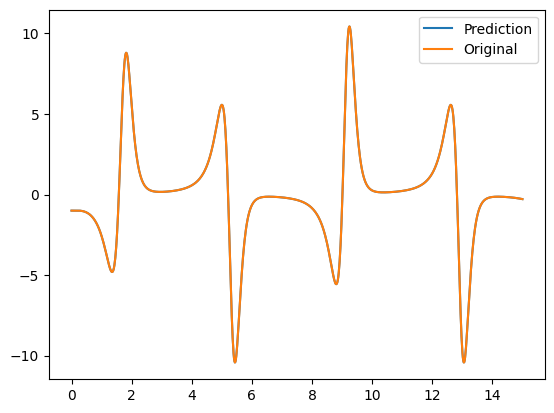

In [43]:
# Plot both scaled values
plt.plot(y_pred_3, label='Prediction')
plt.plot(y2, label='Original')
plt.legend()
plt.show()